```
@title : # Dataset `employee performance` analysis with `Python`
@date  : 20241219 ALUR

@author: Alex Urbon
```


# Intro

To check for gender gaps in our multivariate dataset, we conduct an analysis that includes summary statistics and visualizations.

---

# 1. Import data



In [1]:
import numpy as np
import pandas as pd

raw_data_file_path = '../data/00_original/moondash_data.xlsx'

# Load the data
employee_data = pd.read_excel(raw_data_file_path, sheet_name='Employee Roster')
outcome_data = pd.read_excel(raw_data_file_path, sheet_name='Mid-Year Outcomes')

# Merge the data on employee_id
data_merged = pd.merge(employee_data, outcome_data, on='employee_id')
data_merged.set_index('employee_id', inplace=True)

# Display the first few rows to understand the structure
data_merged.head(2)



,hire_date,job_level,job_function,region,age,gender,perf_rating,promo_decision
employee_id,,,,,,,,
1,2019-09-04,T7,G&A,US2,28.707501,women/non-binary,3-Exceeds Expectations,NaN
2,2023-02-16,T7,Engineering,US1,33.589867,men,3-Exceeds Expectations,NaN


In [2]:
# Check the columns and data types
print(data_merged.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 8012 entries, 1 to 8012
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hire_date       8012 non-null   object 
 1   job_level       8012 non-null   object 
 2   job_function    8012 non-null   object 
 3   region          8012 non-null   object 
 4   age             8012 non-null   float64
 5   gender          8012 non-null   object 
 6   perf_rating     8012 non-null   object 
 7   promo_decision  346 non-null    object 
dtypes: float64(1), object(7)
memory usage: 563.3+ KB
None


In [3]:
# Check for any missing values
print(data_merged.isnull().sum())



hire_date            0
job_level            0
job_function         0
region               0
age                  0
gender               0
perf_rating          0
promo_decision    7666
dtype: int64


---

# 2. Data Prep



In [4]:
data_proc = data_merged



In [5]:
# Excluding records without performance rating
data_proc.shape
data_proc.dropna(subset=['perf_rating'], inplace=True)
data_proc.shape



(8012, 8)

In [6]:
# Truncate `age`
data_proc['age'] = np.round(data_proc['age'], 1)



In [7]:
# Calc: `is_promo`: 1 = Ready, 0 = no value
data_proc.loc[data_proc['promo_decision'].isna(), 'is_promo'] = 0
data_proc.loc[~data_proc['promo_decision'].isna(), 'is_promo'] = 1
data_proc['is_promo'] = data_proc['is_promo'].astype(int)
data_proc.drop(columns='promo_decision', inplace=True)



In [8]:
# `Job`: separate `Role` and `Level`
data_proc['job_role'] = data_proc['job_level'].str[0]
data_proc['job_rank'] = data_proc['job_level'].str[1].astype(int)



In [9]:
# Recode `gender` to `is_men` for statistics
if 'gender' in data_proc.columns: 
    data_proc.loc[data_proc['gender']=='men', 'is_men'] = 1
    data_proc.loc[data_proc['gender']!='men', 'is_men'] = 0
    data_proc['is_men'] = data_proc['is_men'].astype(int)
    data_proc.drop(columns='gender', inplace=True)



In [10]:
# Recode `perf_rating` to perf_rank: only a rating, no text
if 'perf_rating' in data_proc.columns: 
    data_proc['perf_rank'] = data_proc['perf_rating'].str[0].astype(int)
    data_proc.drop(columns='perf_rating', inplace=True)



### Inclusion/Exclusion Criteria



#### Performance Rating

    Exclude non-performers, i.e. `perf_rank` with lower values: 1, 2.



In [11]:
rows_before = data_proc.shape[0]

# Exclude non-performers, i.e. perf_rank = 1 or 2
data_proc.drop(data_proc[data_proc['perf_rank'].isin([1,2])].index, inplace=True)
rows_after = data_proc.shape[0]

print(f'''Input : {rows_before} rows.''')
print(f'''Proc  : {rows_before - rows_after} rows were removed.''')
print(f'''Output: Working with {rows_after} rows. min(`perf_rank`)={min(data_proc['perf_rank'])}''')



Input : 8012 rows.
Proc  : 3774 rows were removed.
Output: Working with 4238 rows. min(`perf_rank`)=3


#### `Tenure`

    New promotion this cycle effective dated 2023-09-30.
    To be eligible for promotion, employees must have a tenure of at least 1.50 years by the 2023-09-30 effective date.
    We include employees that have worked longer than 1.5 year at date of next promotion



In [12]:
### Transform `hire_date` into `tenure` 
next_promotion_date = '2023-09-30'

if 'hire_date' in data_proc.columns:
    # Convert hire_date to datetime
    print(f'''* `hire_date` from {str(min(data_proc['hire_date']))[:10]} to {str(max(data_proc['hire_date']))[:10]}''')
    data_proc['hire_date'] = pd.to_datetime(data_proc['hire_date'])

    # Calculate tenure in years
    data_proc['tenure'] = np.round((pd.to_datetime(next_promotion_date) - data_proc['hire_date']).dt.days / 365.25, 1)
    data_proc[['hire_date', 'tenure']].head(2)
    # remove used variable
    data_proc.drop(columns='hire_date', inplace=True)



* `hire_date` from 2019-08-24 to 2023-03-31


In [13]:
rows_before = data_proc.shape[0]

# Exclude employees not eligible for promotion based on hire_date
data_proc = data_proc[data_proc['tenure'] >= 1]
rows_after = data_proc.shape[0]

print(f'''Input : {rows_before} rows.''')
print(f'''Proc  : {rows_before - rows_after} rows were removed.''')
print(f'''Output: Working with {rows_after} rows. min(`tenure`)={int(min(data_proc['tenure']))}''')



Input : 4238 rows.
Proc  : 510 rows were removed.
Output: Working with 3728 rows. min(`tenure`)=1


### QC before proceeding



In [14]:
# Drop rows with missing values in key columns, if any
data_clean = data_proc.dropna(subset=['perf_rank', 'is_men', 'is_promo'])
data_clean.head(2)



,job_level,job_function,region,age,is_promo,job_role,job_rank,is_men,perf_rank,tenure
employee_id,,,,,,,,,,
1,T7,G&A,US2,28.7,0,T,7,0,3,4.1
4,T6,CXI,US1,28.1,0,T,6,0,4,3.1


In [15]:
# Drop duplicates (if any)
data_clean = data_clean.drop_duplicates()
data_clean.head(2)
print(f'duplicates removed: {data_proc.shape[0] - data_clean.shape[0]} records.')



duplicates removed: 19 records.


In [16]:
# Check the cleaned data
print(data_clean.isnull().sum())



job_level       0
job_function    0
region          0
age             0
is_promo        0
job_role        0
job_rank        0
is_men          0
perf_rank       0
tenure          0
dtype: int64


In [17]:
print(data_clean.dtypes)



job_level        object
job_function     object
region           object
age             float64
is_promo          int32
job_role         object
job_rank          int32
is_men            int32
perf_rank         int32
tenure          float64
dtype: object


In [18]:
# statistics for numeric values
data_clean.describe()



,age,is_promo,job_rank,is_men,perf_rank,tenure
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000
mean,30.956916,0.093287,5.864654,0.552979,3.563494,2.058668
std,2.308005,0.290873,1.362748,0.497252,0.696791,0.792099
min,27.000000,0.000000,4.000000,0.000000,3.000000,1.000000
25%,29.000000,0.000000,5.000000,0.000000,3.000000,1.500000
50%,30.900000,0.000000,6.000000,1.000000,3.000000,2.000000
75%,33.000000,0.000000,7.000000,1.000000,4.000000,2.100000
max,35.000000,1.000000,9.000000,1.000000,5.000000,4.100000


In [19]:
# export clean data set:
data_clean.to_csv('../data/data_clean.csv')



---

# 3: Analysis

    Let's analyze the performance ratings and promotion decisions by gender.



In [20]:
# Performance ratings by gender
data_clean.groupby(['job_role', 'is_men'])['is_promo'].count()
# ALUR: no clear difference



job_role  is_men
I         0         1165
          1         1205
T         0          493
          1          846
Name: is_promo, dtype: int64

In [21]:
# Performance ratings by gender
perf_by_gender = data_clean.groupby('is_men')['perf_rank'].mean()
perf_by_gender



is_men
0    3.551870
1    3.572891
Name: perf_rank, dtype: float64

In [22]:
# Promotion decisions by gender, %
promo_by_gender = np.round(data_clean.groupby('is_men')['is_promo'].value_counts(normalize=True).unstack() * 100, 2)
promo_by_gender



is_promo,0,1
is_men,,
0,90.47,9.53
1,90.83,9.17


### Total Average Promotion Rate 



In [23]:
avg__is_promo = data_clean.groupby('is_promo')['is_promo'].count() / data_clean['is_promo'].count()
print(f'Average Promotion Rate: {np.round(avg__is_promo[1] * 100, 2)}%')



Average Promotion Rate: 9.33%


    Question: what is the average by Role or Level?



In [24]:
avg_promo__by__job_level = np.round(data_clean.groupby('job_level')['is_promo'].mean()*100, 1)
avg_promo__by__job_level



job_level
I4     9.6
I5     9.2
I6     8.0
I7    10.2
T6    11.0
T7     7.6
T8     9.2
T9     9.9
Name: is_promo, dtype: float64

    > ALUR: difference by job level.


In [25]:
print(f'The difference by job level: from {min(avg_promo__by__job_level)}% up to {max(avg_promo__by__job_level)}%')



The difference by job level: from 7.6% up to 11.0%


---

### Differences by `job_role`: not significant



In [26]:
avg__is_promo__by__job_role = np.round(data_clean.groupby('job_role')['is_promo'].mean()*100, 1)
print(avg__is_promo__by__job_role)



job_role
I    9.2
T    9.6
Name: is_promo, dtype: float64


### Differences by `job_rank`: not significant



In [27]:
np.round(data_clean.groupby('job_rank')['is_promo'].mean()*100, 1)



job_rank
4    9.6
5    9.2
6    9.5
7    8.9
8    9.2
9    9.9
Name: is_promo, dtype: float64

---

## Plot results



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# set chart size
plt.rcParams["figure.figsize"] = 5, 3
sns.set_theme(rc={'figure.figsize':(5, 3)})



In [29]:
data_clean.head(2)

,job_level,job_function,region,age,is_promo,job_role,job_rank,is_men,perf_rank,tenure
employee_id,,,,,,,,,,
1,T7,G&A,US2,28.7,0,T,7,0,3,4.1
4,T6,CXI,US1,28.1,0,T,6,0,4,3.1


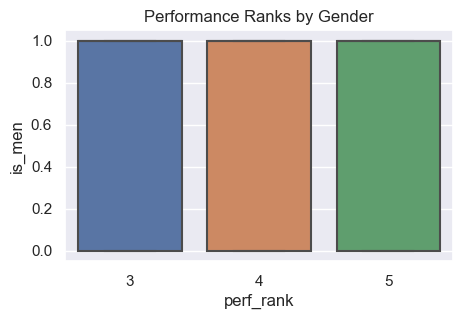

In [30]:
# Performance ratings boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(x='perf_rank', y='is_men', data=data_proc)
plt.title('Performance Ranks by Gender')
plt.show()



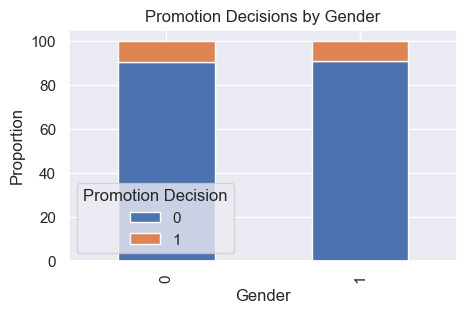

In [31]:
# Promotion decision bar plot
promo_by_gender.plot(kind='bar', stacked=True)
plt.title('Promotion Decisions by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.legend(title='Promotion Decision')
plt.show()



# Boxplots

## Promotion by Performance and Gender



   perf_rank  is_men  is_promo
0          3       0      9.07
1          3       1      9.24
2          4       0      9.68
3          4       1      9.48
4          5       0     11.34
5          5       1      8.00


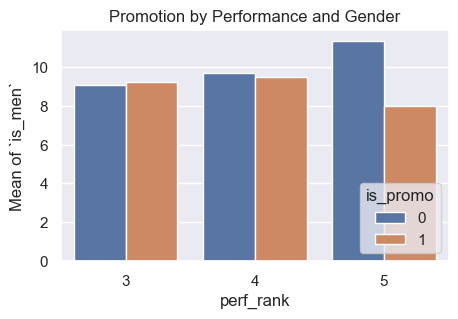

In [32]:
# calculate mean of `x` grouped by`y`:
mean_by_groups = pd.DataFrame(data_clean.groupby(['perf_rank', 'is_men'])['is_promo'].mean().reset_index())
mean_by_groups['is_promo'] = np.round(mean_by_groups['is_promo'] * 100, 2)
print(f'{mean_by_groups}')



plt.figure(figsize=(5,3))
sns.barplot(data=mean_by_groups, x='perf_rank', y='is_promo', hue='is_men')
plt.xlabel('perf_rank')
plt.ylabel('Mean of `is_men`')
plt.title('Promotion by Performance and Gender')
plt.legend(title='is_promo', loc="lower right")
plt.show()



In [33]:
print(data_clean['is_men'].value_counts())



1    2051
0    1658
Name: is_men, dtype: int64


In [34]:
print(data_clean.groupby('is_men')['perf_rank'].describe())



         count      mean       std  min  25%  50%  75%  max
is_men                                                     
0       1658.0  3.551870  0.693986  3.0  3.0  3.0  4.0  5.0
1       2051.0  3.572891  0.699077  3.0  3.0  3.0  4.0  5.0


## Some charts

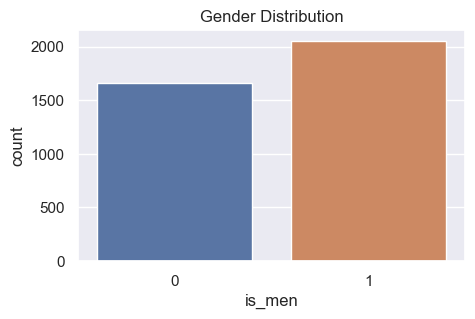

In [35]:
sns.countplot(data=data_clean, x='is_men')
plt.title('Gender Distribution')
plt.show()



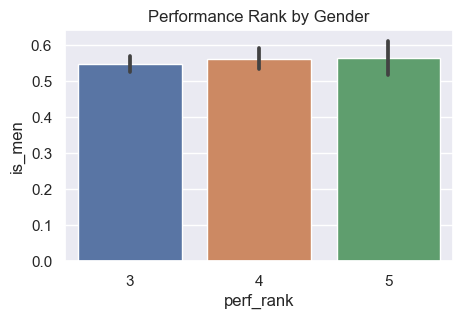

In [36]:
sns.barplot(data=data_clean, x='perf_rank', y='is_men')
plt.title('Performance Rank by Gender')
plt.show()



## Analyze Promotion Rate by Gender: Calculate the promotion rate for each gender



   is_men  is_promo
0       0       9.5
1       1       9.2


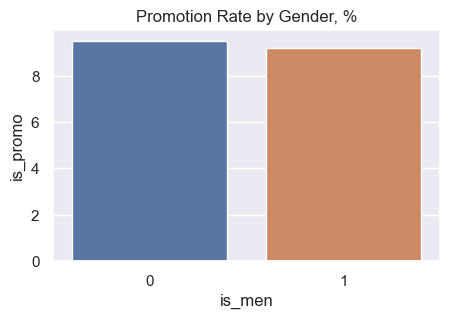

In [37]:
promotion_rate = data_clean.groupby('is_men')['is_promo'].mean().reset_index()
promotion_rate['is_promo'] = np.round(promotion_rate['is_promo'] * 100, 1)
print(promotion_rate)

sns.barplot(data=promotion_rate, x='is_men', y='is_promo')
plt.title('Promotion Rate by Gender, %')
plt.show()



## Cross-tabulation for Detailed Analysis:

    We use cross-tabulation to analyze the relationship between gender and other categorical variables like region, job group, and job level.



In [38]:
pd.crosstab(data_clean['is_men'], data_clean['region'])



region,US1,US2,US3,US4
is_men,,,,
0,686,487,332,153
1,815,606,435,195


In [39]:
pd.crosstab(data_clean['is_men'], data_clean['job_role'])



job_role,I,T
is_men,,
0,1165,493
1,1205,846


In [40]:
pd.crosstab(data_clean['is_men'], data_clean['job_rank'])



job_rank,4,5,6,7,8,9
is_men,,,,,,
0,412,322,466,328,94,36
1,394,310,620,421,221,85


## Advanced Visualization:

Create more complex visualizations, such as comparing performance rank and promotion rates across multiple variables.



In [41]:
data_clean.describe()



,age,is_promo,job_rank,is_men,perf_rank,tenure
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000
mean,30.956916,0.093287,5.864654,0.552979,3.563494,2.058668
std,2.308005,0.290873,1.362748,0.497252,0.696791,0.792099
min,27.000000,0.000000,4.000000,0.000000,3.000000,1.000000
25%,29.000000,0.000000,5.000000,0.000000,3.000000,1.500000
50%,30.900000,0.000000,6.000000,1.000000,3.000000,2.000000
75%,33.000000,0.000000,7.000000,1.000000,4.000000,2.100000
max,35.000000,1.000000,9.000000,1.000000,5.000000,4.100000


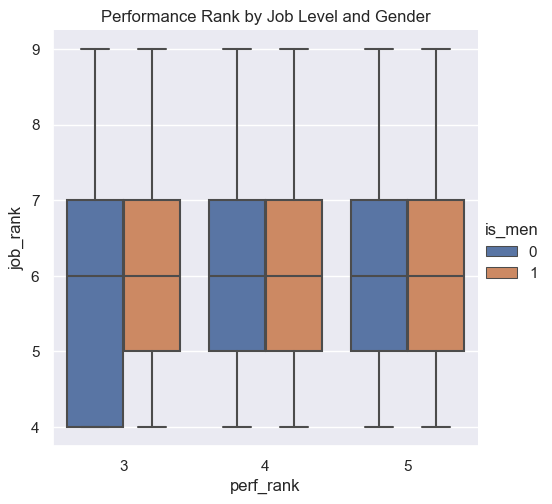

In [42]:
sns.catplot(data=data_clean, x='perf_rank', y='job_rank', hue='is_men', kind='box')
plt.title('Performance Rank by Job Level and Gender')
plt.show()



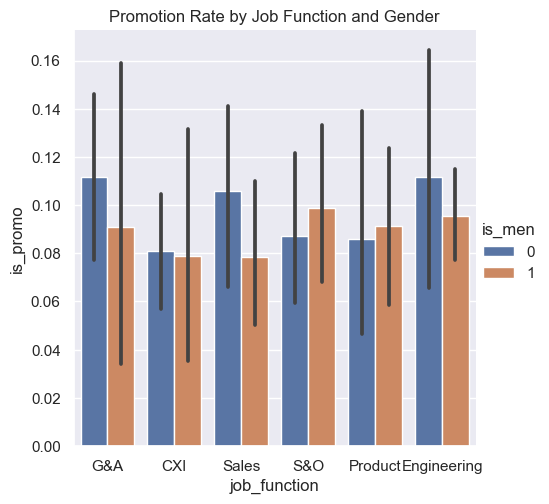

In [43]:
sns.catplot(data=data_clean, x='job_function', y='is_promo', hue='is_men', kind='bar')
plt.title('Promotion Rate by Job Function and Gender')
plt.show()



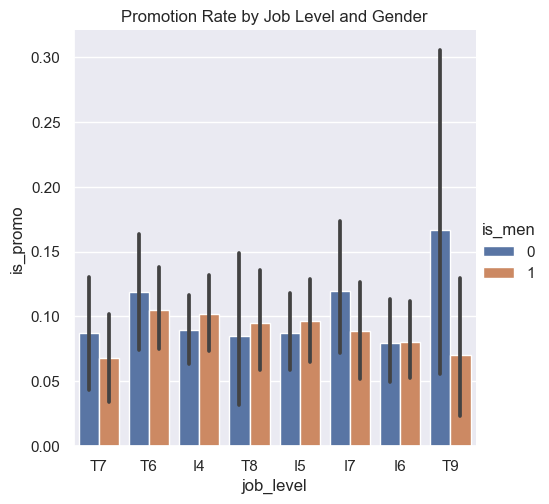

In [44]:
sns.catplot(data=data_clean, x='job_level', y='is_promo', hue='is_men', kind='bar')
plt.title('Promotion Rate by Job Level and Gender')
plt.show()



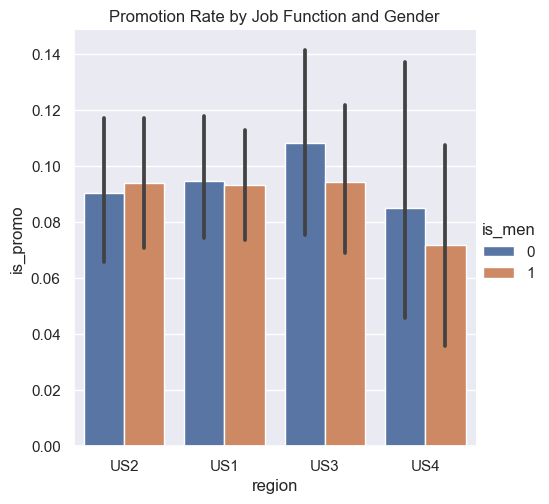

In [45]:
sns.catplot(data=data_clean, x='region', y='is_promo', hue='is_men', kind='bar')
plt.title('Promotion Rate by Job Function and Gender')
plt.show()



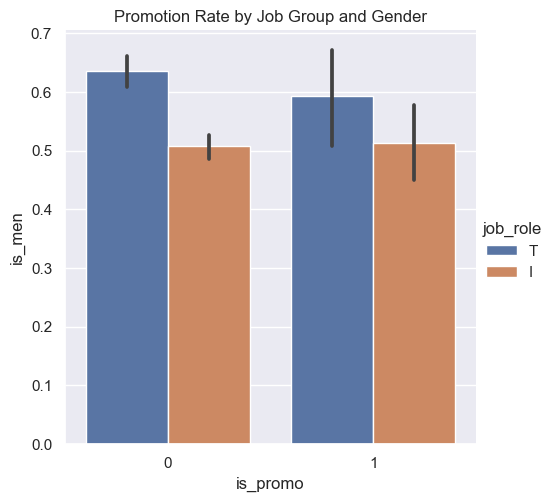

In [46]:
sns.catplot(data=data_clean, x='is_promo', y='is_men', hue='job_role', kind='bar')
plt.title('Promotion Rate by Job Group and Gender')
plt.show()



# Data Insights:

    After data analysis, we have a clearer picture of possible gender gaps in performance, promotions, and other job-related metrics.

    We can further refine the analysis based on specific findings or delve deeper into areas showing disparities.



# 4. Statistical Testing:

Using `t-test` to check if there is a significant difference in performance scores based on `gender` and `promotion rank`.



In [47]:
data_clean.head(2)



,job_level,job_function,region,age,is_promo,job_role,job_rank,is_men,perf_rank,tenure
employee_id,,,,,,,,,,
1,T7,G&A,US2,28.7,0,T,7,0,3,4.1
4,T6,CXI,US1,28.1,0,T,6,0,4,3.1


### Test for `Performance Rank`



In [48]:
from scipy import stats

# Separate performance scores by gender
male_performance = data_clean[data_clean['is_men'] == 1]['perf_rank']
female_performance = data_clean[data_clean['is_men'] == 0]['perf_rank']

# Perform a t-test for performance scores by gender 
t_stat_performance, p_val_performance = stats.ttest_ind(male_performance, female_performance)
print("\nT-test for performance scores by gender:")
print(f"T-statistic: {np.round(t_stat_performance, 3)}, p-value: {np.round(p_val_performance, 3)}")

# Check if the p-value is less than 0.05 for significance
if p_val_performance < 0.05: print("There is a significant difference in performance scores by gender.")
else: print("No significant difference in performance scores by gender.")




T-test for performance scores by gender:
T-statistic: 0.913, p-value: 0.361
No significant difference in performance scores by gender.


### Test for `Gender`



In [49]:
# Check promotion rates by gender using a Chi-Square test 
promotion_male = data_clean[data_clean['is_men'] == 1]['is_promo'].value_counts()
promotion_female = data_clean[data_clean['is_men'] == 0]['is_promo'].value_counts()

# Perform a Chi-Square test for promotion rates
chi2_stat, p_val_promotion, dof, expected = stats.chi2_contingency([promotion_male, promotion_female])
print("\nChi-Square test for promotion rates by gender:") 
print(f"Chi2 statistic: {np.round(chi2_stat, 3)}, p-value: {np.round(p_val_promotion, 3)}") 
# Check if the p-value is less than 0.05 for significance
if p_val_promotion < 0.05: print("There is a significant difference in promotion rates by gender.")
else: print("No significant difference in promotion rates by gender.") 




Chi-Square test for promotion rates by gender:
Chi2 statistic: 0.103, p-value: 0.748
No significant difference in promotion rates by gender.


---

# 6. Actionable Insights & Recommendations:

    * The data does not show inequalities in performance and promotion about gender.

    * Propose solutions based on your findings: 
        * If there is a gap in promotions despite equal performance, suggest a more transparent promotion process.
        * If there's bias in performance reviews, recommend bias training for managers.
        * If there’s a lag in time to promotion for one gender, suggest a more equitable pathway for career advancement, with clear timelines and expectations for both genders.





---

# 7. Final Thoughts for the Assignment:


    * Be Transparent:
        If there are gaps in the data or areas where you couldn't make a solid conclusion, be honest about it.
        Transparency will always be appreciated.

    * Communicate Clearly:
        When you present your findings, make sure to keep it simple and focused.
        They want to know the key issues and what to do about them.

    * Contextualize Your Findings:
        If relevant, refer to external studies or best practices to back up your recommendations, showing that you’re not just talking numbers but also understanding the broader picture of workplace gender equity.



# Next Steps:

    * Use these insights to make recommendations for addressing any gender inequalities you find.

    * If any biases or disparities were found, we could consider introducing more transparent criteria for performance evaluations, or promoting unconscious bias training.



# Conclusion:

    With these steps, we have an in-depth, data-driven approach to assess gender inequalities in our dataset.

    We did not find significant differences in performance, promotions, or time to promotion, which leaves little room to recommend ways to make the workplace even more equitable for everyone.

